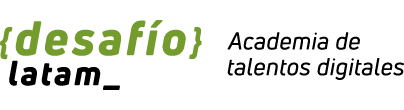

#<center><font color ='green'>Modelos de ensamble</font></center>

Ajustaremos un modelo de ensamble Bagging y un Random Forest para datos de precios de viviendas de Boston, para comparar sus respectivos rendimients. Utilizaremos para esto una base de datos con información referente a las viviendas y el barrio en el que estan ubicadas. El objetivo es predecir el precio mediano de una vivienda, con la información de sus predictores.

Las variables presentes en el dataset son:

1. CRIM: tasa de delincuencia per cápita por ciudad
2. ZN: proporción de suelo residencial con parcelas de más de 25.000 pies cuadrados.
3. INDUS: proporción de acres comerciales no minoristas por ciudad
4. CHAS: variable ficticia Charles River (1 si la zona colinda con el río; 0 en caso contrario)
5. NOX: concentración de óxidos nítricos (partes por 10 millones).
6. RM: número medio de habitaciones por vivienda
7. EDAD: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
8. DIS: distancias ponderadas a cinco centros de empleo de Boston
9. RAD: índice de accesibilidad a autopistas radiales
10. TAX: tipo del impuesto sobre bienes inmuebles por cada 10.000 $ [$/10k].
11. PTRATIO: ratio alumnos-profesor por ciudad
12. B: resultado de la ecuación B=1000(Bk - 0,63)^2 donde Bk es la proporción de personas de color por ciudad
13. LSTAT: % de estatus inferior de la población

Variable de salida:
1) MEDV: Valor mediano de las viviendas ocupadas por sus propietarios en miles de $ [k$].

##Carga de bibliotecas y datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('boston.csv')
df.sample(10)

CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD    TAX  \
214  0.28955   0.0  10.59     0  0.489  5.412    9.8  3.5875    4  277.0   
177  0.05425   0.0   4.05     0  0.510  6.315   73.4  3.3175    5  296.0   
253  0.36894  22.0   5.86     0  0.431  8.259    8.4  8.9067    7  330.0   
258  0.66351  20.0   3.97     0  0.647  7.333  100.0  1.8946    5  264.0   
52   0.05360  21.0   5.64     0  0.439  6.511   21.1  6.8147    4  243.0   
89   0.05302   0.0   3.41     0  0.489  7.079   63.1  3.4145    2  270.0   
188  0.12579  45.0   3.44     0  0.437  6.556   29.1  4.5667    5  398.0   
254  0.04819  80.0   3.64     0  0.392  6.108   32.0  9.2203    1  315.0   
185  0.06047   0.0   2.46     0  0.488  6.153   68.8  3.2797    3  193.0   
205  0.13642   0.0  10.59     0  0.489  5.891   22.3  3.9454    4  277.0   

     PTRATIO       B  LSTAT  MEDV  
214     18.6  348.93  29.55  23.7  
177     16.6  395.60   6.29  24.6  
253     19.1  396.90   3.54  42.8  
258     13.0  383.29   7.79  36.0  
52      16.8  396.90   5.28  25.0  
89      17.8  396.06   5.70  28.7  
188     15.2  382.84   4.56  29.8  
254     16.4  392.89   6.57  21.9  
185     17.8  387.11  13.15  29.6  
205     18.6  396.90  10.87  22.6

In [ ]:
# contando valores ausentes
[(x1, np.sum(x2.isnull())) for x1, x2 in df.items()]

[('CRIM', 0),
 ('ZN', 0),
 ('INDUS', 0),
 ('CHAS', 0),
 ('NOX', 0),
 ('RM', 0),
 ('AGE', 0),
 ('DIS', 0),
 ('RAD', 0),
 ('TAX', 0),
 ('PTRATIO', 0),
 ('B', 0),
 ('LSTAT', 0),
 ('MEDV', 0)]

## Segmentación train and test

In [ ]:
RSTATE = 23124

X = df.drop(columns=['MEDV'], axis=1)
y = df['MEDV']

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=RSTATE)


print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

X_train: (339, 13)
X_test: (167, 13)


## Modelo de Árbol de decisión (Regresión)

In [ ]:
model1 = DecisionTreeRegressor(random_state=RSTATE)

# training
model1.fit(X_train, y_train)

# prediction para conjunto de test
yhat_test = model1.predict(X_test)

# prediction para conjunto de test
yhat_train = model1.predict(X_train)

# medir el desempeño del modelo conjunto de train
print('\n---\nConjunto de train')
print(f'r2: {r2_score(y_train, yhat_train)}')
print(f'MSE: {mean_squared_error(y_train, yhat_train)}')


# medir el desempeño del modelo conjunto de test
print('\n---\nConjunto de test')
print(f'r2: {r2_score(y_test, yhat_test)}')
print(f'MSE: {mean_squared_error(y_test, yhat_test)}')
print('---\n')


---
Conjunto de train
r2: 1.0
MSE: 0.0

---
Conjunto de test
r2: 0.630473540012213
MSE: 32.03700598802395
---



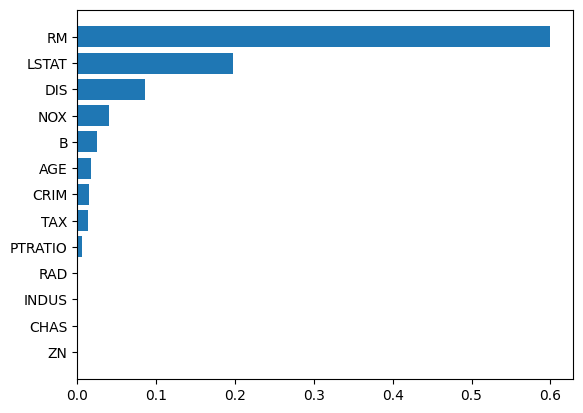

In [ ]:
# visualizar importancia de los atributos del modelo

idx_sort = np.argsort(model1.feature_importances_)
plt.barh(y=model1.feature_names_in_[idx_sort], width=model1.feature_importances_[idx_sort]);

## Modelo de ensamble Bagging

Veremos ahora el funcionamiento de un modelo Bagging, utilizando para ello 100 árboles de regresión. Es posible utilizar también otros modelos predictivos, pero por defecto la función de Python utiliza árboles

In [ ]:
model2 = BaggingRegressor(n_estimators=100, oob_score=True, random_state=RSTATE, n_jobs=-1)

'''
n_estimators=100: indica el número de estimadores (modelos base) en el conjunto.
En este caso, estás utilizando 100 regresores base.

oob_score=True: calcula el rendimiento fuera de la bolsa (out-of-bag score). Es
útil para tener una estimación adicional del rendimiento del modelo sin necesidad
 de un conjunto de prueba separado.

random_state=RSTATE: establece la semilla para la reproducibilidad del modelo.
Si se utiliza la misma semilla, se obtendrán los mismos resultados en cada ejecución.

n_jobs=-1: indica el número de trabajadores (núcleos de CPU) que se utilizarán
para entrenar los modelos base de forma paralela. En este caso, se utiliza -1 para utilizar todos los núcleos disponibles.
'''


# training
model2.fit(X_train, y_train)

# prediccion para conjunto de test
yhat_test = model2.predict(X_test)

# prediccion para conjunto de train
yhat_train = model2.predict(X_train)

# medir el desempeño del modelo conjunto de train
print('\n---\nConjunto de train')
print(f'r2: {r2_score(y_train, yhat_train)}')
print(f'MSE: {mean_squared_error(y_train, yhat_train)}')


# medir el desempeño del modelo conjunto de test
print('\n---\nConjunto de test')
print(f'r2: {r2_score(y_test, yhat_test)}')
print(f'MSE: {mean_squared_error(y_test, yhat_test)}')
print('---\n')


---
Conjunto de train
r2: 0.9796552579405595
MSE: 1.6845849528023595

---
Conjunto de test
r2: 0.8612559344399523
MSE: 12.02875826347305
---



### Estimación de r2 con datos OOB

In [ ]:
model2.oob_score_

0.8509121206992635

## Modelo de ensamble Random Forest

In [ ]:
model3 = RandomForestRegressor(max_features='sqrt', random_state=RSTATE, oob_score=True, n_jobs=-1) # 100 árboles

# training
model3.fit(X_train, y_train)

# prediction para conjunto de test
yhat_test = model3.predict(X_test)

# prediction para conjunto de test
yhat_train = model3.predict(X_train)

# medir el desempeño del modelo conjunto de train
print('\n---\nConjunto de train')
print(f'r2: {r2_score(y_train, yhat_train)}')
print(f'MSE: {mean_squared_error(y_train, yhat_train)}')


# medir el desempeño del modelo conjunto de test
print('\n---\nConjunto de test')
print(f'r2: {r2_score(y_test, yhat_test)}')
print(f'MSE: {mean_squared_error(y_test, yhat_test)}')
print('---\n')


---
Conjunto de train
r2: 0.9795047494149792
MSE: 1.6970473569321496

---
Conjunto de test
r2: 0.8653377151332012
MSE: 11.674878239520936
---



### Estimación de $r^2$ con datos OOB

In [ ]:
model3.oob_score_

0.8500979526808392

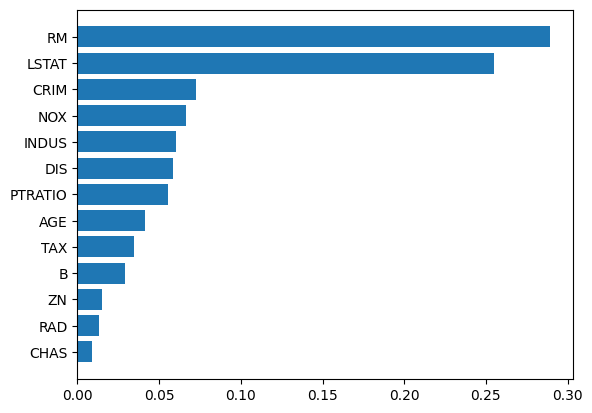

In [ ]:
# visualizar importancia de los atributos del modelo

idx_sort = np.argsort(model3.feature_importances_)
plt.barh(y=model3.feature_names_in_[idx_sort], width=model3.feature_importances_[idx_sort]);

## Ajuste de hiper parámetros

In [ ]:
%%time
# permite medir el tiempo de ejecución de la celda en la que se encuentra. Esto
# dará el tiempo total que lleva ejecutar la búsqueda de hiperparámetros.

param_grid = {
    'n_estimators': np.linspace(50, 200, 50, dtype='int'),
    'max_features': ['sqrt', 'log2', None]
}

'''
Define la cuadrícula de hiperparámetros que se probarán durante la búsqueda.
Estamos probando diferentes valores para el número de estimadores (n_estimators)
 y las características máximas (max_features) en cada árbol.
'''

grid_model4 = GridSearchCV(
    RandomForestRegressor(oob_score=True, random_state=RSTATE),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5
)
'''
Se realiza la búsqueda de hiperparámetros utilizando validación cruzada. Se le
pasa el modelo base (RandomForestRegressor con algunos parámetros predeterminados),
 la cuadrícula de hiperparámetros (param_grid), el número de trabajadores a
 utilizar en paralelo (n_jobs=-1 significa utilizar todos los núcleos
 disponibles), y el número de divisiones para la validación cruzada
 (cv=5 significa validación cruzada de 5 pliegues).
'''


grid_model4.fit(X_train, y_train)


CPU times: user 3.75 s, sys: 414 ms, total: 4.16 s
Wall time: 3min 43s


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(oob_score=True,
                                             random_state=23124),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': array([ 50,  53,  56,  59,  62,  65,  68,  71,  74,  77,  80,  83,  86,
        89,  92,  95,  98, 102, 105, 108, 111, 114, 117, 120, 123, 126,
       129, 132, 135, 138, 141, 144, 147, 151, 154, 157, 160, 163, 166,
       169, 172, 175, 178, 181, 184, 187, 190, 193, 196, 200])})

In [ ]:
print('\n---')
print('Mejores valores de hiper parámetros encontrados:')
print(grid_model4.best_params_)
print('---\n')


---
Mejores valores de hiper parámetros encontrados:
{'max_features': None, 'n_estimators': 68}
---



In [ ]:
# prediction para conjunto de test
yhat_test = grid_model4.best_estimator_.predict(X_test)

# prediction para conjunto de test
yhat_train = grid_model4.best_estimator_.predict(X_train)

# medir el desempeño del modelo conjunto de train
print('\n---\nConjunto de train')
print(f'r2: {r2_score(y_train, yhat_train)}')
print(f'MSE: {mean_squared_error(y_train, yhat_train)}')


# medir el desempeño del modelo conjunto de test
print('\n---\nConjunto de test')
print(f'r2: {r2_score(y_test, yhat_test)}')
print(f'MSE: {mean_squared_error(y_test, yhat_test)}')
print('---\n')


---
Conjunto de train
r2: 0.979732473487267
MSE: 1.6781913525430974

---
Conjunto de test
r2: 0.8663437637003881
MSE: 11.587656382736247
---



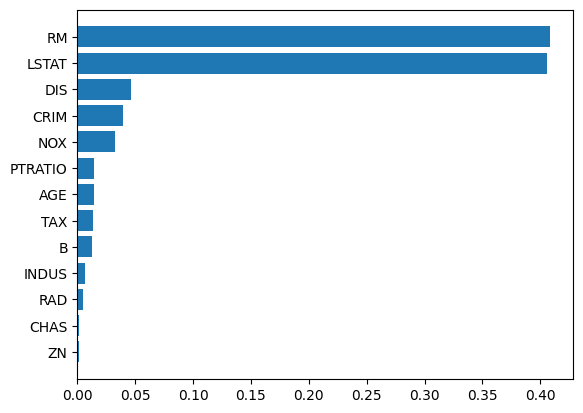

In [ ]:
# visualizar importancia de los atributos del modelo
model4 = grid_model4.best_estimator_
idx_sort = np.argsort(model4.feature_importances_)
plt.barh(y=model4.feature_names_in_[idx_sort], width=model4.feature_importances_[idx_sort]);

### Medición de r2 desde datos OOB

In [ ]:
model4.oob_score_

0.8469798799197839

### Predicción de un caso particular

In [ ]:
# CRIM: 2.24236
# ZN: 0.0
# INDUS: 19.58
# CHAS: 0
# NOX: 0.605
# RM: 5.854
# AGE: 91.8
# DIS: 2.4220
# RAD: 5
# TAX: 403.0
# PTRATIO: 14.7
# B = 395.11
# LSTAT: 11.64

#####
# Valor esperado para la vivienda: 22.7
#####
obs = X_test.loc[[164]]

print('Predicción')
model4.predict(obs)

Predicción


array([21.81029412])